In [12]:
from fredapi import Fred
import os
import matplotlib.pyplot as plt


start= "2018-01-03"
end  = "2022-02-25"

key = os.environ.get('FRED_KEY')
fred = Fred(api_key=key)
dgs10 = fred.get_series('DGS10',observation_start=start, observation_end=end)
dgs2  = fred.get_series('DGS2',observation_start=start, observation_end=end)
tb3   = fred.get_series('TB3MS',observation_start=start, observation_end=end)
dgs10_2 = dgs10-dgs2
sp500   = fred.get_series('SP500',observation_start=start, observation_end=end)


<AxesSubplot:>

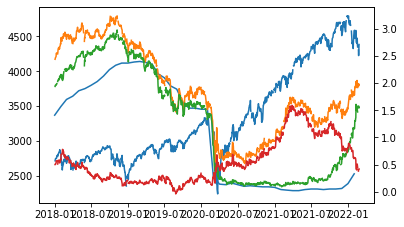

In [28]:
import matplotlib.pyplot as plt

fig,ax1 = plt.subplots()
ax1.plot(sp500)
ax2 = ax1.twinx()
ax2.plot(tb3)
dgs10.plot()
dgs2.plot()
dgs10_2.plot()